<a href="https://colab.research.google.com/github/nudojacopo/Conversation_dynamics/blob/main/src/SYN/focus/saturation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

Cloning into 'thesis'...
remote: Enumerating objects: 1841, done.
remote: Counting objects: 100% (568/568), done.
remote: Compressing objects: 100% (272/272), done.
remote: Total 1841 (delta 351), reused 474 (delta 293), pack-reused 1273
Receiving objects: 100% (1841/1841), 81.89 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (1172/1172), done.
Mounted at /content/drive


In [2]:
import pandas as pd

# Load the data
fb = pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')
rd = pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_PRO.csv')
vo = pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_PRO.csv')
gb = pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')

## Prepare Data

(23,)
(23,)
(23,)
(23,)


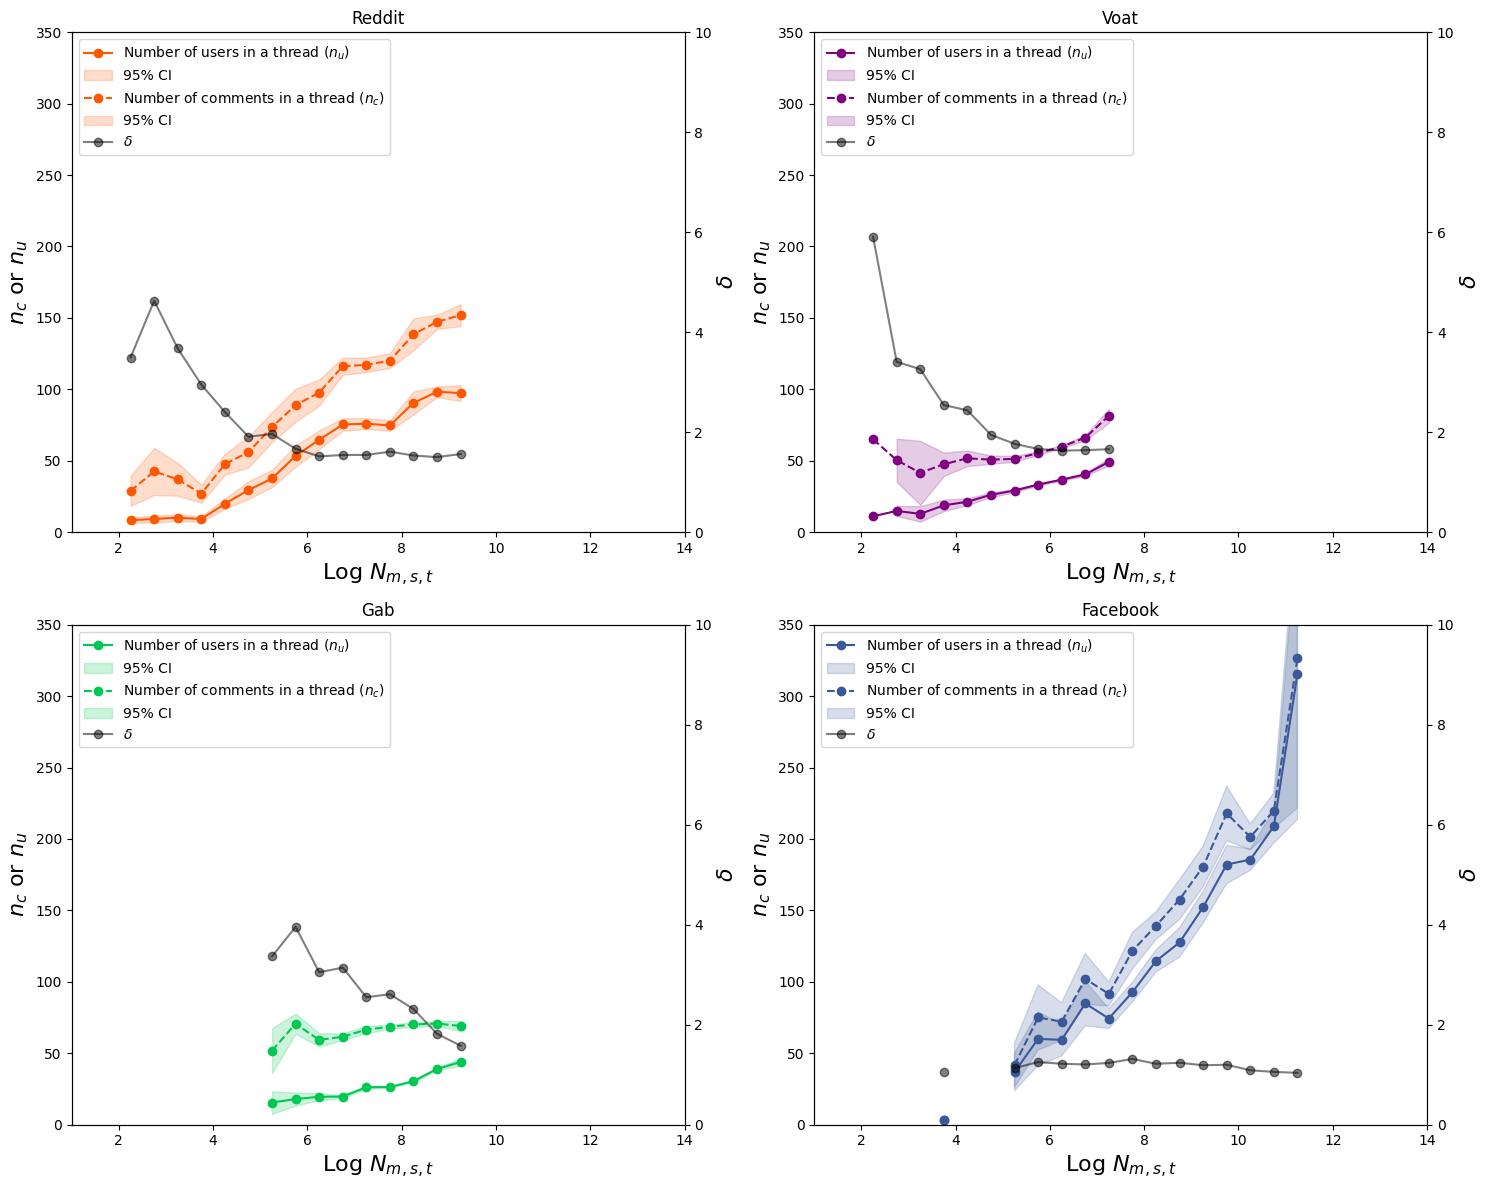

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the color palette
palette = {
    'Reddit': '#FF5700',   # Reddit orange
    'Voat': '#800080',     # Voat purple
        'Gab': '#00c853'  ,     # Gab green
    'Facebook': '#3b5998', # Facebook blue
}

# Assume dfs = [rd, vo, gb, fb] are your dataframes corresponding to the platforms
# And these are the names of the platforms
platform_names = ['Reddit', 'Voat', 'Gab', 'Facebook']
 # Flatten the 2x2 array of axes for easy iteration
h=100
def process_df_utenti(df, platform_name,h):
  df = filter_first_h(df, h)  # Assuming filter_first_h is a function you have defined
  # Create the 'month-year' column
  df['month-year'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-W%U')
  df['unique_users'] = df.groupby(['month-year','topic'])['user_id'].transform('nunique')

  # Group by and rename columns
  unique_users_count = df.groupby(['unique_users', 'post_id'])['user_id'].nunique().reset_index(name='n_u')

  # Group by 'unique_users' and 'post_id' to count the number of comments
  comments_count = df.groupby(['unique_users', 'post_id'])['comment_id'].count().reset_index(name='n_c')

  # Merge the two results
  df = pd.merge(unique_users_count, comments_count, on=['unique_users', 'post_id'])

  # Rename columns to match the desired output
  df.columns = ['unique_users', 'post_id', 'n_u', 'n_c']
  df['delta']=(df['n_c']/df['n_u'])
  bins = np.arange(2, 14, 0.5)  # The upper bound is 14 to include 12 in the last bin
  df['bin'] = pd.cut(np.log(df['unique_users']), bins=bins, right=False)  # right=False to include the left edge
  bin_edges = pd.IntervalIndex(df['bin'].cat.categories).mid.values
  print(bin_edges.shape)
  # Calculate median and confidence intervals of log_nc for each bin
  bin_yu = df.groupby('bin')['n_u'].agg(['mean', 'std', 'count']).reset_index()
  bin_yc = df.groupby('bin')['n_c'].agg(['mean', 'std', 'count']).reset_index()
  #bin_yd = df.groupby('bin')['delta'].agg(['mean', 'std', 'count']).reset_index()
  bin_yd =pd.DataFrame(bin_yc['mean']/bin_yu['mean'])
  # Calculate the 95% confidence intervals
  # We use the formula for the confidence interval of the median: median ± 1.96 * (std / sqrt(count))
  z_value = 1.98  # Critical value for 80% confidence
  bin_yu['ci_lower'] = bin_yu['mean'] - z_value * (bin_yu['std'] / np.sqrt(bin_yu['count']))
  bin_yu['ci_upper'] = bin_yu['mean'] + z_value * (bin_yu['std'] / np.sqrt(bin_yu['count']))
  bin_yc['ci_lower'] = bin_yc['mean'] - z_value * (bin_yc['std'] / np.sqrt(bin_yc['count']))
  bin_yc['ci_upper'] = bin_yc['mean'] + z_value * (bin_yc['std'] / np.sqrt(bin_yc['count']))
  return bin_edges,bin_yu, bin_yc,bin_yd
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 grid
axes = axes.flatten()  # Flatten to iterate easily

for ax, df, platform_name in zip(axes, dfs, platform_names):
    # Calculate the data
    bin_edges, bin_stats, bin_stats2, bin_stats3 = process_df_utenti(df, platform_name, h)

    # Plot the main data on the first y-axis
    ax.plot(bin_edges, bin_stats['mean'], marker='o', linestyle='-', color=palette[platform_name], label='Number of users in a thread ($n_{u}$)')
    ax.fill_between(bin_edges, bin_stats['ci_lower'], bin_stats['ci_upper'], color=palette[platform_name], alpha=0.2, label='95% CI')
    ax.plot(bin_edges, bin_stats2['mean'], marker='o', linestyle='--', color=palette[platform_name], label='Number of comments in a thread ($n_{c}$)')
    ax.fill_between(bin_edges, bin_stats2['ci_lower'], bin_stats2['ci_upper'], color=palette[platform_name], alpha=0.2, label='95% CI')

    # Create the secondary y-axis
    ax2 = ax.twinx()
    ax2.plot(bin_edges, bin_stats3['mean'], marker='o', linestyle='-', color='black', label=r'$\delta$', alpha=0.5)
    ax2.set_ylim(0, 10)  # Set the range for the secondary y-axis

    # Label and customize the secondary y-axis
    ax2.set_ylabel(r'$\delta$', fontsize=16)
    ax2.tick_params(axis='y', labelcolor='black')

    # Customize the main y-axis
    ax.set_title(f'{platform_name}')
    ax.set_xlabel('Log $N_{m,s,t}$', fontsize=16)
    ax.set_ylabel('$n_{c}$ or $n_{u}$', fontsize=16)
    ax.set_xlim(1, 14)
    ax.set_ylim(0, 350)

    # Add legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [115]:
df = filter_first_h(vo, h)  # Assuming filter_first_h is a function you have defined
# Create the 'month-year' column
df['month-year'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-W%U')
df['unique_users'] = df.groupby(['month-year','topic'])['user_id'].transform('nunique')

# Group by and rename columns
unique_users_count = df.groupby(['unique_users', 'post_id'])['user_id'].nunique().reset_index(name='n_u')

# Group by 'unique_users' and 'post_id' to count the number of comments
comments_count = df.groupby(['unique_users', 'post_id'])['comment_id'].count().reset_index(name='n_c')

# Merge the two results
df = pd.merge(unique_users_count, comments_count, on=['unique_users', 'post_id'])

# Rename columns to match the desired output
df.columns = ['unique_users', 'post_id', 'n_u', 'n_c']
df['delta']=(df['n_c']/df['n_u'])
df=df.dropna(subset=['n_c','n_u'])
bins = np.arange(2, 14, 0.5)  # The upper bound is 14 to include 12 in the last bin
df['bin'] = pd.cut(np.log(df['unique_users']), bins=bins, right=False)  # right=False to include the left edge
bin_edges = pd.IntervalIndex(df['bin'].cat.categories).mid.values
print(bin_edges.shape)
# Calculate median and confidence intervals of log_nc for each bin
bin_yu = df.groupby('bin')['n_u'].agg(['mean', 'std', 'count']).reset_index()
bin_yc = df.groupby('bin')['n_c'].agg(['mean', 'std', 'count']).reset_index()
bin_yd =pd.DataFrame(bin_yc['mean']/bin_yu['mean'])



,mean
0,5.909091
1,3.406015
2,3.258427
3,2.541448
4,2.435447
5,1.945161
6,1.764283
7,1.662082
8,1.630323
9,1.637627


array([ 2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5])

nu vs nc

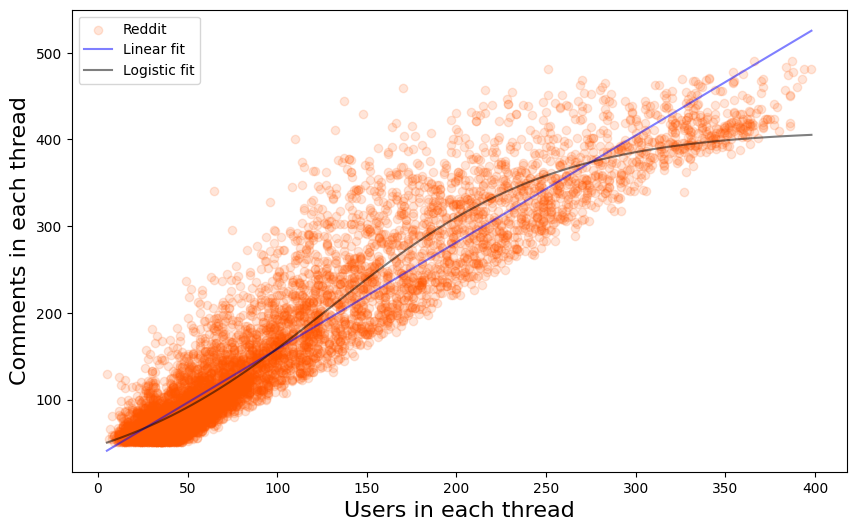

Linear fit AIC: 55927.61, BIC: 55941.50
Logistic fit AIC: 55143.63, BIC: 55164.47


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

# Assuming 'rd' DataFrame is already defined with 'post_id', 'user_id', and 'comment_id'

# Step 1: Create the series
nu = rd.groupby('post_id')['user_id'].unique()
nc = rd.groupby('post_id')['comment_id'].count()

# Step 2: Convert series to DataFrame
nu_df = nu.apply(len).reset_index(name='unique_users')  # Counting unique users
nc_df = nc.reset_index(name='comment_count')

# Step 3: Merge DataFrames on 'post_id'
merged_df = pd.merge(nu_df, nc_df, on='post_id')

# Step 5: Fit linear model
def linear_model(x, a, b):
    return a * x + b

popt_linear, pcov_linear = curve_fit(linear_model, merged_df['unique_users'], merged_df['comment_count'])

# Step 6: Fit logistic model
def logistic_model(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

popt_logistic, pcov_logistic = curve_fit(logistic_model, merged_df['unique_users'], merged_df['comment_count'], p0=[max(merged_df['comment_count']), 1, np.median(merged_df['unique_users'])])

# Step 7: Calculate AIC and BIC for each model
def calculate_aic(y, y_pred, num_params):
    resid = y - y_pred
    ss_resid = np.sum(resid**2)
    n = len(y)
    aic = n * np.log(ss_resid / n) + 2 * num_params
    return aic

def calculate_bic(y, y_pred, num_params):
    resid = y - y_pred
    ss_resid = np.sum(resid**2)
    n = len(y)
    bic = n * np.log(ss_resid / n) + num_params * np.log(n)
    return bic

# Predictions
y_pred_linear = linear_model(merged_df['unique_users'], *popt_linear)
y_pred_logistic = logistic_model(merged_df['unique_users'], *popt_logistic)

# Calculate AIC and BIC
aic_linear = calculate_aic(merged_df['comment_count'], y_pred_linear, len(popt_linear))
bic_linear = calculate_bic(merged_df['comment_count'], y_pred_linear, len(popt_linear))
aic_logistic = calculate_aic(merged_df['comment_count'], y_pred_logistic, len(popt_logistic))
bic_logistic = calculate_bic(merged_df['comment_count'], y_pred_logistic, len(popt_logistic))

# Step 8: Visualize fit and compare models
x_values = np.linspace(min(merged_df['unique_users']), max(merged_df['unique_users']), 100)

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['unique_users'], merged_df['comment_count'], label='Reddit', color='#FF5700', alpha=0.15)
plt.plot(x_values, linear_model(x_values, *popt_linear), label='Linear fit',color='blue', alpha=0.5)
plt.plot(x_values, logistic_model(x_values, *popt_logistic), label='Logistic fit', color='black' ,alpha=0.5)
plt.xlabel('Users in each thread', fontsize=16)
plt.ylabel('Comments in each thread', fontsize=16)
plt.legend()

plt.show()

# Print AIC and BIC
print("Linear fit AIC: {:.2f}, BIC: {:.2f}".format(aic_linear, bic_linear))
print("Logistic fit AIC: {:.2f}, BIC: {:.2f}".format(aic_logistic, bic_logistic))
